# "A Journey Through Fastbook (AJTFB) - Chapter 4: Stochastic Gradient Descent"
> "The fourth in a weekly-ish series where I revisit the fast.ai book, [\"Deep Learning for Coders with fastai & PyTorch\"](https://github.com/fastai/fastbook), and provide commentary on the bits that jumped out to me chapter by chapter.  So without further adieu, let's go!"

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, fastbook]
- image: images/articles/fastbook.jpg

Other posts in this series:  
[A Journey Through Fastbook (AJTFB) - Chapter 1](https://ohmeow.com/posts/2020/11/06/ajtfb-chapter-1.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 2](https://ohmeow.com/posts/2020/11/16/ajtfb-chapter-2.html)  
[A Journey Through Fastbook (AJTFB) - Chapter 3](https://ohmeow.com/posts/2020/11/22/ajtfb-chapter-3.html)



In [2]:
# hide
!pip install fastai>=2.3 --upgrade

import fastai
from fastai.vision.all import *
print(fastai.__version__ )

/home/kurianbenoy/mambaforge/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/kurianbenoy/mambaforge/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


2.6.3


---
## How to visualize a grayscale image in pandas ...

In [3]:
mnist_path = untar_data(URLs.MNIST_SAMPLE)
mnist_path.ls()

(#3) [Path('/home/kurianbenoy/.fastai/data/mnist_sample/labels.csv'),Path('/home/kurianbenoy/.fastai/data/mnist_sample/valid'),Path('/home/kurianbenoy/.fastai/data/mnist_sample/train')]

In [4]:
sample_3 = Image.open((mnist_path/'train/3').ls().sorted()[1])
sample_3

In [5]:
sample_3_t = tensor(sample_3)
df = pd.DataFrame(sample_3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


---
## What is a baseline model and why do you want one?

> A simple model that you are confident should perform reasonably well. It should be
> simple to implement and easy to test

**Why do you want to start with a baseline model?**
> ... without starting with a sensible baseline, it is difficult to know whether your super-fancy models are any good

**How do you build/find one of these models?**

You can search online for folks that have trained models to solve a problem similar to your's and/or you can start with one of the high-level examples in the fastai docs against your data.  There are a bunch covering core vision, text, tabuluar and colab filtering tasks right [here](https://docs.fast.ai/tutorial.html).



---
## Tensors

**What is a "Tensor"?**

Like a numpy array, but with GPU support.  The data it contains must be of the ***same type*** and must conform in ***rectangular shape***.

> Important: "try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors"


Let's take a look ..

In [6]:
threes = (mnist_path/'train/3').ls().sorted()
len(threes), threes[0]

(6131, Path('/home/kurianbenoy/.fastai/data/mnist_sample/train/3/10.png'))

In [7]:
all_threes = [ tensor(Image.open(fp)) for fp in threes ]
len(all_threes), all_threes[0].shape

(6131, torch.Size([28, 28]))

In [8]:
stacked_threes = torch.stack(all_threes).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Important information about tensors include its `shape`, `rank`, and `type`:

In [9]:
# shape = the length of each axis
print('shape: ', stacked_threes.shape)

# rank = the total number of axes
print('rank: ', stacked_threes.ndim)

# type = the datatype of its contents
print('type: ', stacked_threes.dtype)

shape:  torch.Size([6131, 28, 28])
rank:  3
type:  torch.float32


Important things you can do to a tensor, `view`, `@`, `where`

In [10]:
# view = change the shape of a tensor without changing its contents
stacked_threes_rank_2 = stacked_threes.view(-1, 28*28)
print('orig. shape: ', stacked_threes.shape)
print('make into a rank 2 tensor', stacked_threes_rank_2.shape)

# @ = operator for matrix multiplication
print('result of matrix multiplication: ', (stacked_threes @ torch.randn((1,28,28))).shape)

# where = torch.where(a,b,c) => [b[i] if a[i] else c[i] for i in range(len(a))] ... see p.167
trgs = tensor([1,0,1])
preds = tensor([0.9, 0.4, 0.2])

def mnist_loss(preds, targs):
  return torch.where(targs == 1, 1 - preds, preds).mean()

print('output of where: ', mnist_loss(preds, trgs))

orig. shape:  torch.Size([6131, 28, 28])
make into a rank 2 tensor torch.Size([6131, 784])
result of matrix multiplication:  torch.Size([6131, 28, 28])
output of where:  tensor(0.4333)


For an interactive lesson on matrix multiplication, [this is the best](http://matrixmultiplication.xyz/)!

Check out pp.145-148 to learn about "broadcasting", a critical piece to understanding how you can and should manipulate tensors or numpy arrays!

---
## Stochastic Gradient Descent - How to train a model



Here are the steps:

1. **INITIALIZE** the weights = initializing parameters to random values

2. For each image, **PREDICT** whether it is a 3 or 7
 
3. Based on the predictions, calculate how good the model is by calculating its **LOSS** (small is good)

4. Calculate the **GRADIENT**, ***"which measures for each weight how changing the weight would change the loss"***

5. **STEP**, change all the weights based on the gradient

6. Starting at step 2, **REPEAT**

7. **STOP** when you don't want to train any longer or the model is good enough

Below, we'll delve deeper into these steps. We'll do this by getting a big more into the sample code beginning on p.150 ...

### Step 1: Initializing weights

One way is presented on p.164:
```
def init_params(size, std=1.0) return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1)) #=> returns a rank 2, 784x1 tensor, with random values
```

### Step 3: Calculating the loss

> Important: "For continuous data, it's common to use *mean squared error*".  In order to understand how to write this, read it right-to-left (e.g., error -> square -> mean)

```
def mse(preds, targs): return ((preds-targs)**2).mean()

# in PyTorch
loss = F.mse_loss(preds, targs)
```

> Important: Accuracy is a bad loss function


**Why is accuracy a poor loss function?**

> "The gradient of a funciton is its slope, or its steepness ... how much the value of the function goes up or down, divided by how much we changed the input `(y_new - y_old) / (x_new - x_old)` .... The problem with [accuracy] is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, so `(y_new - y_old)` will almost always be 0 ... **the gradient is 0 almost everywhere.  A very small change in the value of a weight will often not change the accuracy at all

A gradient = 0 will mean that the weights aren't updated.

> Important: "We need a loss function that, when our weights result in slightly better predictions, gives us a slightly better loss"


**Metrics v. Loss**

> Important: "... ***the metric is to drive human understanding*** and ***the loss is to drive automated learning***.


> Important: "... focus on these metrics, rather than the loss, when judging the performance of a model."


> Important: "... the loss must be a function that has a meaningful derivative ... must be reasonably smooth [so] that [it] would respond to small changes in confidence level.


The loss function is one that can be optimized using its gradient!

### Step 4: Calculating the gradients

> Important: "the gradients ***tell us how much we have to change each weight*** to make our model better ... allows us to more quickly calculate whether our loss will go up or down we we make those adjustments"



> Important: "The gradients ***tell us only the slope of our function***; they don't tell us exactly how far to adjust the parameters. But they do give us some idea of how far" (large slope = bigger adjustments needed whereas a small slope suggests we are close to the optimal value)


"The ***derivative*** of a function tells you how much a change in its parameters will change its result"

Remember: We are calculating a gradient for *EVERY* weight so we know how to adjust it to make our model better (i.e., lower the LOSS)

`requires_grad` tells PyTorch "that we want to calculate gradients with respect to that variable at that value"

In [13]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max,steps=100)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

Here we pretend that the below is our **loss function**.  Running a number through it, our **weight** will produce a result, an **activation** ... in this case, our **loss** (which again is a value telling us how good or bad our model is; smaller = good)

In [14]:
xt = tensor(-1.5).requires_grad_(); xt

tensor(-1.5000, requires_grad=True)

Loss:  2.25


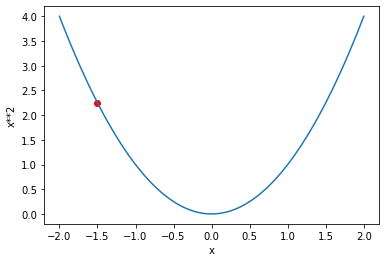

In [15]:
def f(x): return x**2
loss = f(xt)

plot_function(f, 'x', 'x**2')
plt.scatter(xt.detach().numpy(), loss.detach().numpy(), color='red')
print('Loss: ', loss.item())

So if our parameter is `-1.5` we get a loss = `2.25`. Since the direction of our slope is downward (negative), by changing its value to be a bit more positive, we get closer to achieving our goal of *minimizing our loss*

Loss:  1.0


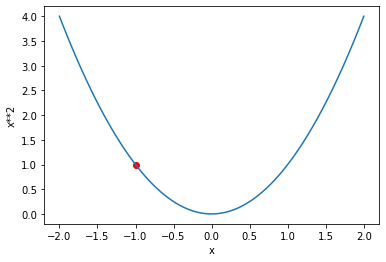

In [16]:
xt = tensor(-1.).requires_grad_(); xt

loss = f(xt)

plot_function(f, 'x', 'x**2')
plt.scatter(xt.detach().numpy(), loss.detach().numpy(), color='red')
print('Loss: ', loss.item())

And yes, our loss has improved!  If the direction of our slope were upwards (positive), we would conversely want `x` to be smaller.

***BUT*** now ... imagine having to figure all this out for a million parameters.  Obviously, we wouldn't want to try doing this manually as we did before, and thanks to PyTorch, we don't have too :)

Remember that by utilizing the `requires_grad_()` function, we have told PyTorch to keep track of how to compute the gradients based on the other calucations we perform, like running it through our loss function above.  Let's see what that looks like.

In [17]:
xt = tensor(-1.).requires_grad_(); 
print(xt)

loss = f(xt)
print(loss)

tensor(-1., requires_grad=True)
tensor(1., grad_fn=<PowBackward0>)


That `<PowBackward0>` is the gradient function it will use to calculate the gradients when needed.  And when we need it, we call the `backward` method to do so.

In [18]:
loss.backward()
print(xt.grad)

tensor(-2.)


And the calcuated gradient is exactly what we expected given that to calculate the derivate of `x**2` is `2x` ... `2*-1 = -2`.

Again, the gradient tells us ***the slope of our function***.  Here have a a negative/downward slope and so at the very least, we know what moving in that direction will get us closer to the minimum.

The question is now, **How far do we move in that direction?**

### Step 5: Change all the weights based on the gradient using a "Learning Rate"

The **learning rate** (or LR) is a number (usually a small number like 1e-3 or 0.1) that we multiply the gradient by to get a better parameter value.  For a given parameter/weight `w`, the calculation looks like this:

` w -= w.grad * lr`

Notice we take the negative of the grad * lr operation because we want to move in the opposite direction.

> Important: We do this in a `with torch.no_grad()` so that we don't calculate the gradient for the gradient calculating operation

In [19]:
lr = 0.01

with torch.no_grad():
 xt -= xt.grad * lr

 print('New value for xt: ', xt)
 print('New loss: ', f(xt))

New value for xt:  tensor(-0.9800, requires_grad=True)
New loss:  tensor(0.9604)


You can see the loss get smaller which is exactly what we want!  "The magnitude of the gradient (i.e., the steepness of the slope) [tells] us how big a step to take."

The above operation is also called the **optimization step**

See pp.156-157 for examples of what using a too small or too large LR might look like when training.  This could help you troubleshoot things if yours looks wonky.

---
## Datasets & DataLoaders






A **Dataset** contains tuples of independent and dependent variables

In [20]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

A **DataLoader** receives a dataset and gives us back as many *mini-batches* are necessary based on the *batch size* we specify

In [21]:
dl = DataLoader(ds, bs=6, shuffle=True)
list(dl)

[(tensor([21,  6,  4, 15, 12,  9]), ('v', 'g', 'e', 'p', 'm', 'j')),
 (tensor([ 5,  3, 13, 17,  2,  1]), ('f', 'd', 'n', 'r', 'c', 'b')),
 (tensor([ 7, 25, 10, 23,  8, 16]), ('h', 'z', 'k', 'x', 'i', 'q')),
 (tensor([ 0, 24, 20, 22, 18, 14]), ('a', 'y', 'u', 'w', 's', 'o')),
 (tensor([19, 11]), ('t', 'l'))]

---
## Measuring distances

See pp.141-142.  There are two main ways to measure distances.

**L1 norm** (or mean absolute difference): Take the mean of the absolute value of differences

` l1_loss = (tensor_a - tensor_b).abs().mean()`

**L2 norm** (or root mean squared error, RMSE): Take the square root of the mean of the square differences. The squaring of differences makes everything positive and the square root undoes the squaring.

> Important: "... the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes)"


` l2_loss = ((tensor_a - tensor_b) ** 2).sqrt()`






---
## Important PyTorch Modules

A **module** is a class that inherits from PyTorch's `nn.Module` class. "Every PyTorch module knows that **parameters** it has that can be trained."

Here are some key ones ...


### `nn.Linear`

Initializes its parameters and performs a linear operation.  It contains both the weights and biases in a single class

In [22]:
lin1 = nn.Linear(28*28, 1)

# the trainable parameters
weights, bias = lin1.parameters()
print(weights.shape, bias.shape)

torch.Size([1, 784]) torch.Size([1])


### `nn.ReLU`

Allows us to add a non-linearity between linear classifiers.  Simply put, it ensures that all activations passed to it are a positive number with every negative number replaced with a 0.  

Notice below that it has no trainable parameters!

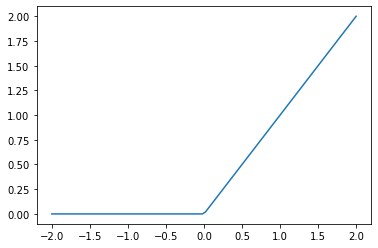

In [23]:
plot_function(F.relu)

In [24]:
non_lin1 = nn.ReLU()
print(list(non_lin1.parameters()))

print('using nn.ReLU: ', non_lin1(tensor(-1)), non_lin1(tensor(4)))
print('using max()', tensor(-1).max(tensor(0.0)), tensor(4).max(tensor(0.0)))

[]
using nn.ReLU:  tensor(0) tensor(4)
using max() tensor(0.) tensor(4.)


**Why do you want to have non-linearities?**

> Because "there's no point in just putting one linear layout directly after another one, because when we multiply things together and then add them up multiple times, that could be replaced by multiplying different things together and adding them up just once .... BUT if we put a non-linear between them ... this is no longer true. ***Now each linear layer is somewhat decoupled from the other ones and can do its own useful work***."

These kind of functions are also called **"activation functions"**, because the only operate and produce activations ... there are no trainable parameters.


### `nn.Sequential`

A module that can be passed modules, which when called, calls each of those layers in turn.

In [25]:
lin2 = nn.Linear(1, 10)
seq_model = nn.Sequential(lin1, non_lin1, lin2)

seq_params = list(seq_model.parameters())
print(len(seq_params))

for p in seq_params: print(p.shape)

4
torch.Size([1, 784])
torch.Size([1])
torch.Size([10, 1])
torch.Size([10])


Why `4`?  Simple, remember that each `nn.Linear` above has two trainable parameters (the weights and bias), 2+2 = 4.

---
## Summary

This chapter walks you through creating a baseline model to a full blown training loop in PyTorch. ***Read it, and read it again and again!*** (I have done it).

**Important Vocb/Concepts**

*Activations*: Numbers that are calculated by both linear and non-linear layers

*Parameters*: Randomly initialized parameters that can be trained.

*Neural Network*: A chain of linear and non-linear functions your data runs through to produce a result.

*Gradient*: "The derivative of the loss with respect to some parameter of the model"

*Backpropagation*: The computing of the gradients "of the loss with respect to all model parameters"

*Gradient Descent*: "Taking a step in the direction opposite to the gradients to make the model parameters a little bit better"


---

## Resources

1. https://book.fast.ai - The book's website; it's updated regularly with new content and recommendations from everything to GPUs to use, how to run things locally and on the cloud, etc...
